In [1]:
pip install torch torchvision opencv-python open3d timm matplotlib pillow pyvista

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import torch
import numpy as np
import open3d as o3d
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors
import pyvista as pv
from PIL import Image


In [3]:
img_path = "forest.png"
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)

# Convert PIL to NumPy array
img_np = np.array(img_pil)

# Load MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", trust_repo=True)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Transform and predict
input_batch = midas_transforms(img_np)
with torch.no_grad():
    prediction = midas(input_batch)
    depth = prediction.squeeze().cpu().numpy()

# Combine with original RGB
depth_resized = cv2.resize(depth, (img_rgb.shape[1], img_rgb.shape[0]))
encoded_matrix = np.dstack((img_rgb, depth_resized))  # (H, W, 4)

Using cache found in /Users/rexouyang/.cache/torch/hub/intel-isl_MiDaS_master
/opt/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /Users/rexouyang/.cache/torch/hub/intel-isl_MiDaS_master


In [4]:
#turn this into 3d cloud
H, W, _ = encoded_matrix.shape
flattened = encoded_matrix.reshape(-1, 4)  # shape (H*W, 4)

points_xyz = []
colors_rgb = []

for idx, (r, g, b, d) in enumerate(flattened):
    i = idx // W  # row
    j = idx % W   # column
    x, y, z = j, i, d  # simple mapping

    points_xyz.append([x, y, z])
    colors_rgb.append([r/255.0, g/255.0, b/255.0])


In [5]:
#make clusters
#logic: go through each point and find nearby points in its vicintiy. make triangles. 
#def distance(point1, point2):
#    point1, point2 = np.array(point1), np.array(point2)
#    return math.sqrt(np.sum((point1-point2)**2))

#def connection_poisson_reconstruction()



#Cluster algorithm 1
try:
    import open3d as o3d
except ImportError:
    o3d = None

def poisson_surface_reconstruction(points_xyz, colors_rgb, depth=8, normal_radius=0.1, max_nn=30):
    """
    Poisson Surface Reconstruction using Open3D.

    Args:
        points_xyz (array-like[N, 3]): 3D point coordinates.
        colors_rgb (array-like[N, 3]): RGB colors (0-255 range) for each point.
        depth (int): Depth parameter for the Poisson solver (higher = finer resolution).
        normal_radius (float): Radius for normal estimation.
        max_nn (int): Maximum number of neighbors for normal estimation.

    Returns:
        vertices (np.ndarray[M, 3]): Mesh vertices.
        triangles (np.ndarray[K, 3]): Triangle indices.
        vertex_colors (np.ndarray[M, 3]): Colors for each vertex.
    """
    if o3d is None:
        raise ImportError("Open3D is required for Poisson reconstruction. Install via `pip install open3d`")
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(points_xyz))
    colors = np.asarray(colors_rgb) / 255.0  # normalize to [0,1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn)
    )
    
    # Poisson reconstruction
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=depth)
    
    # Crop the mesh to the bounding box of the original points
    bbox = pcd.get_axis_aligned_bounding_box()
    mesh = mesh.crop(bbox)
    
    # Extract arrays
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    vertex_colors = np.asarray(mesh.vertex_colors)
    
    return vertices, triangles, vertex_colors


def poisson_surface_reconstruction_fast(
    points_xyz,
    colors_rgb,
    depth=8,                # lower depth for speed
    normal_radius=None,
    max_nn=30,
    voxel_size=5.0,         # down-sample grid size (increase → faster)
    remove_outliers=True,   # clean spurious points
    nb_neighbors=20,
    std_ratio=2.0,
    target_triangles=20000, # mesh decimation target
    hole_size=1e4           # smaller hole fill limit
):
    """
    Faster Poisson + hole fill pipeline with downsampling & decimation.
    """
    # 1) Build & clean point cloud
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.asarray(points_xyz)))
    pcd.colors = o3d.utility.Vector3dVector(np.asarray(colors_rgb, float) / 255.0)

    # 2) Voxel downsample
    pcd = pcd.voxel_down_sample(voxel_size)

    # 3) Remove statistical outliers
    if remove_outliers:
        pcd, _ = pcd.remove_statistical_outlier(nb_neighbors, std_ratio)

    # 4) Estimate normals
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg_dist = float(dists.mean())
    if normal_radius is None:
        normal_radius = avg_dist * 2.0
    pcd.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn))
    pcd.orient_normals_consistent_tangent_plane(100)

    # 5) Poisson reconstruction (lower depth → faster)
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=depth, scale=1.1, linear_fit=True
    )
    mesh = mesh.crop(pcd.get_axis_aligned_bounding_box())

    # 6) Decimate mesh (reduce triangle count)
    mesh = mesh.simplify_quadric_decimation(target_number_of_triangles=target_triangles)

    # 7) Extract arrays
    verts = np.asarray(mesh.vertices)
    tris  = np.asarray(mesh.triangles)
    cols  = (np.asarray(mesh.vertex_colors) * 255).astype(np.uint8)

    # 8) Convert to PyVista and fill holes (smaller hole_size)
    faces = np.hstack([np.full((len(tris),1),3,dtype=int), tris])
    pvmesh = pv.PolyData(verts, faces)
    pvmesh.point_data['colors'] = (cols / 255.0)  # normalized
    pvmesh = pvmesh.fill_holes(hole_size)

    # 9) Pull back into NumPy
    new_verts = pvmesh.points
    new_tris  = pvmesh.faces.reshape(-1,4)[:,1:]
    new_cols  = (pvmesh.point_data['colors'] * 255).astype(np.uint8)

    return new_verts, new_tris, new_cols



def ball_pivoting_reconstruction(points_xyz, colors_rgb,
                                 radii=None,
                                 normal_radius=None,
                                 max_nn=30):
    """
    Ball‐Pivoting Surface Reconstruction using Open3D.

    Args:
        points_xyz      : array-like [N×3] of float coordinates.
        colors_rgb      : array-like [N×3] of uint8 colors in 0–255.
        radii           : list of float pivot radii; if None, auto‐computed.
        normal_radius   : radius for normal estimation; if None, auto‐computed.
        max_nn          : max neighbors for normal estimation.

    Returns:
        vertices   : np.ndarray[M×3] of mesh vertices.
        triangles  : np.ndarray[K×3] of vertex indices (triangles).
        vert_colors: np.ndarray[M×3] of vertex RGB colors (0–255 uint8).
    """
    import numpy as np
    import open3d as o3d

    # Build point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(points_xyz))
    rgb01 = np.asarray(colors_rgb, dtype=float) / 255.0
    pcd.colors = o3d.utility.Vector3dVector(rgb01)

    # Auto normal_radius if missing
    if normal_radius is None:
        dists = pcd.compute_nearest_neighbor_distance()
        normal_radius = float(np.mean(dists)) * 2.0
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=normal_radius, max_nn=max_nn
        )
    )
    pcd.orient_normals_consistent_tangent_plane(100)

    # Auto‐compute radii from nearest‐neighbor spacing
    if radii is None:
        avg_dist = float(np.mean(pcd.compute_nearest_neighbor_distance()))
        radii = [avg_dist * f for f in (1.5, 3.0, 6.0)]

    # Ball‐pivoting
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )
    mesh.vertex_colors = pcd.colors
    mesh.compute_vertex_normals()

    # extract arrays
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    vert_colors = (np.asarray(mesh.vertex_colors) * 255).astype(np.uint8)

    return vertices, triangles, vert_colors



def ball_pivoting_reconstruction_optimized(points_xyz,
                                 colors_rgb,
                                 radii=None,
                                 normal_radius=None,
                                 max_nn=30,
                                 voxel_size=None,
                                 remove_outliers=True,
                                 nb_neighbors=20,
                                 std_ratio=2.0):
    """
    Optimized Ball‐Pivoting Surface Reconstruction using Open3D.

    Optimizations included:
      1. Optional voxel down‐sampling to reduce point count.
      2. Optional statistical outlier removal to clean noise.
      3. Single nearest‐neighbor‐distance pass to compute both normal_radius and pivot radii.
      4. Consistent normal orientation.
      5. In‐place operations and fewer array conversions.

    Args:
        points_xyz      : array-like [N×3] of float coordinates.
        colors_rgb      : array-like [N×3] of uint8 colors in 0–255.
        radii           : list of float pivot radii; if None, auto‐computed.
        normal_radius   : radius for normal estimation; if None, auto‐computed.
        max_nn          : max neighbors for normal estimation.
        voxel_size      : float, if provided will down‐sample the cloud to this voxel size.
        remove_outliers : bool, whether to apply statistical outlier removal.
        nb_neighbors    : int, neighbors to consider for outlier removal.
        std_ratio       : float, standard deviation multiplier for outlier removal.

    Returns:
        vertices   : np.ndarray[M×3] of mesh vertices.
        triangles  : np.ndarray[K×3] of vertex indices (triangles).
        vert_colors: np.ndarray[M×3] of vertex RGB colors (0–255 uint8).
    """
    # Build point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(points_xyz))
    pcd.colors = o3d.utility.Vector3dVector(np.asarray(colors_rgb, float) / 255.0)

    # 1) Voxel down‐sample if requested
    if voxel_size is not None:
        pcd = pcd.voxel_down_sample(voxel_size)

    # 2) Remove statistical outliers if requested
    if remove_outliers:
        pcd, ind = pcd.remove_statistical_outlier(
            nb_neighbors=nb_neighbors,
            std_ratio=std_ratio
        )

    # 3) Compute average nearest‐neighbor distance (single pass)
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg_dist = float(dists.mean())

    # 4) Determine radii and normal_radius from the same statistics
    if normal_radius is None:
        normal_radius = avg_dist * 2.0
    if radii is None:
        radii = [avg_dist * f for f in (1.5, 3.0, 6.0)]

    # 5) Estimate normals with a hybrid KD‐tree search
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius,
                                                          max_nn=max_nn)
    )
    # Orient normals to point consistently outward
    pcd.orient_normals_consistent_tangent_plane(100)

    # 6) Run ball‐pivoting
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )

    # 7) Transfer colors & compute mesh normals
    mesh.vertex_colors = pcd.colors
    mesh.compute_vertex_normals()

    # 8) Extract arrays only once at the end
    vertices   = np.asarray(mesh.vertices)
    triangles  = np.asarray(mesh.triangles)
    vert_colors= (np.asarray(mesh.vertex_colors) * 255).astype(np.uint8)

    return vertices, triangles, vert_colors

In [6]:
def plot_textured_mesh(vertices, triangles, image_path, title="Textured Mesh"):
    """
    Plot a 3D mesh with an image texture wrapped onto it using PyVista,
    including coordinate axes, a back-plane grid, and a longer X-axis.

    Args:
        vertices (np.ndarray[M, 3]): Array of vertex coordinates.
        triangles (np.ndarray[K, 3]): Array of triangle indices.
        image_path (str): Path to the texture image.
        title (str): Title of the plot.
    """
    # Build a PyVista PolyData: each face is [3, i0, i1, i2]
    faces = np.hstack([
        np.full((triangles.shape[0], 1), 3, dtype=int),
        triangles.astype(int),
    ])
    mesh = pv.PolyData(vertices, faces)

    mesh.scale([3.0, 1.0, 1.0], inplace=True)


    # Generate UVs by projecting onto the XY-plane of the mesh bounds
    mesh.texture_map_to_plane(inplace=True)

    # Load your image as a texture
    texture = pv.read_texture(image_path)

    # Create a Plotter
    p = pv.Plotter()
    p.add_text(title, font_size=14)

    # 1) Corner axes widget, but capture the actor
    axes_actor = p.add_axes()          # shows the little XYZ triad in the corner

    # 1b) Stretch the X-axis twice as long as Y and Z
    axes_actor.SetTotalLength(1.0, 1.0, 1.0)

    # 2) Axis labels on the main scene
    p.show_axes()         # ensures X, Y, Z labels are drawn

    # 3) Back-plane grid
    p.show_grid(color='gray', grid='back')  

    # Add your textured mesh
    p.add_mesh(mesh, texture=texture, show_edges=False)

    # Finally display
    #p.view_xy()        # look down +Z (i.e. from above onto the XY plane)
    #p.view_xz()        # look down +Y (i.e. from above onto the XZ plane)
    #p.view_yz()        # look down +X (i.e. from above onto the YZ plane)
    #p.view_isometric() # true isometric, from (1,1,1) direction


    # Finally display
    p.show()

/opt/anaconda3/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


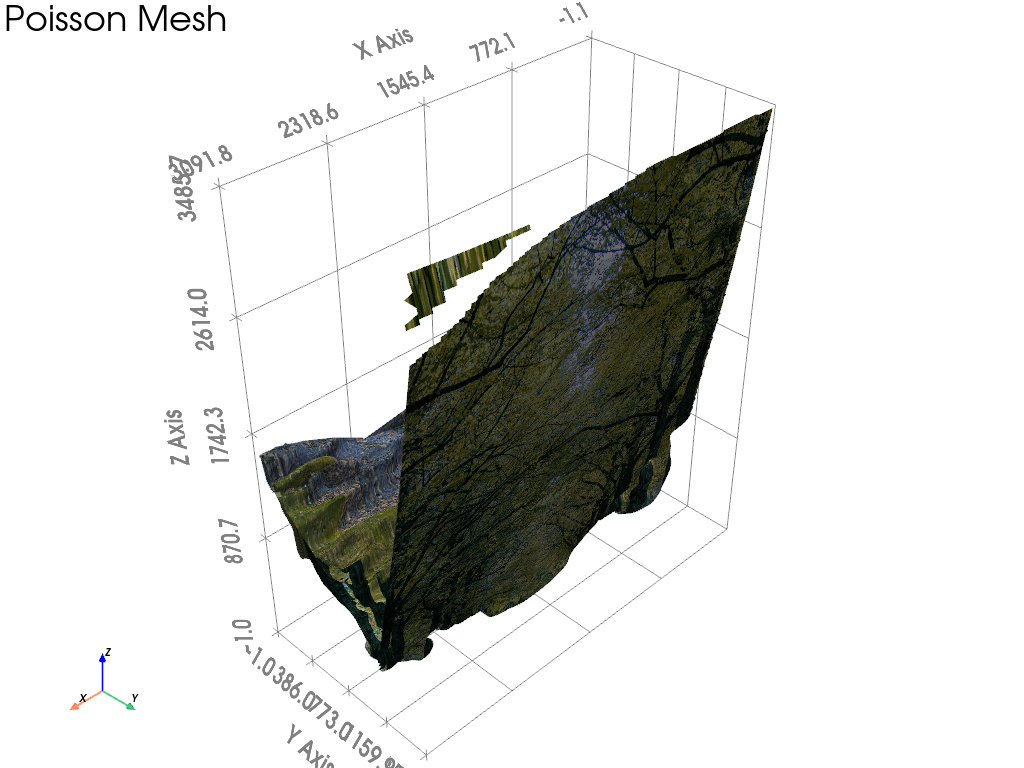

In [7]:
verts, tris, cols = poisson_surface_reconstruction_fast(points_xyz, colors_rgb)
plot_textured_mesh(verts, tris, img_path, title="Poisson Mesh")



#verts, tris, cols = ball_pivoting_reconstruction_optimized(points_xyz, colors_rgb)
#plot_textured_mesh(verts, tris, img_path, title="Ball Pivoting Mesh")
